# Ensemble Failure Prediction Notebook

**Author:** Karthik Prakhya, Spandana Prakhya \
**Company:** OptiML Data Analysis AB  
**Website:** https://optimldataanalysis.se  
**Contact:** info@optimldataanalysis.se    

**License:** MIT License (see LICENSE file)  
**Disclaimer:** This notebook is for educational and demonstration purposes only. All data used are synthetic or publicly available; no confidential or client-specific information is included.

---


## Executive Summary

This notebook is a demonstration of methods used in an AI/ML & optimization problem. It uses synthetic or public datasets and is intended to illustrate methodology, not to present results from client engagements.

**Key objectives:**
- Demonstrate approach and pipeline
- Provide a reproducible example for technical reviewers
- Highlight business impact where appropriate

**Tools Used:** Python, NumPy, pandas, matplotlib, and standard optimization/ML libraries (e.g., OR-Tools, Gurobi, scikit-learn, TensorFlow/PyTorch).

---



# Ensemble Machine Learning for Failure Prediction
### Combining LSTM (temporal deep learning) and Gradient Boosted Trees  
### With Mock Azure IoT Integration


## 1. Introduction

We will explore an **ensemble approach** that blends deep learning (LSTM) with gradient boosting (LightGBM) for **failure prediction** using time-series sensor data.

The key idea is to model temporal dependencies using an LSTM network while capturing aggregated feature-level patterns with a LightGBM model. These are combined via a **stacking ensemble** with a logistic regression meta-model.

---

### Mathematical motivation
Let $x_{t}^{(i)} \in \mathbb{R}^{d}$ be the sensor readings of unit $i$ at time $t$, and let $y_t^{(i)} \in \{0,1\}$ denote whether a failure occurs (or is imminent) at time $t$.

Our goal is to learn a function
$$ f: (x_{t-w+1}, \dots, x_t) \mapsto \hat{y}_t $$
that predicts the probability of failure in the near future, where $w$ is the sequence window length.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random, os, json, time

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)



## 2. Synthetic Data Generation

We simulate $N$ units, each producing multivariate time series with $d$ sensors over $T$ timesteps. A small proportion of units experience a **failure event**, which we model by an increase in sensor drift before the event.

We denote the dataset as:
$$ \mathcal{D} = \{ (x_t^{(i)}, y_t^{(i)}) \}_{i=1,t=1}^{N,T} $$


In [17]:

def generate_synthetic_data(n_units=200, seq_len=400, n_sensors=5, failure_rate=0.05):
    rows = []
    for unit in range(n_units):
        base = np.random.normal(0, 1, size=(seq_len, n_sensors))
        drift = np.linspace(0, np.random.normal(0.5, 1.0), seq_len)[:, None]
        base += drift

        fail_times = set()
        if np.random.rand() < failure_rate:
            ft = np.random.randint(50, seq_len - 1)
            fail_times.add(ft)
            for s in range(n_sensors):
                base[max(0, ft-20):ft, s] += np.linspace(0, np.random.uniform(1.0, 5.0), min(20, ft))

        for t in range(seq_len):
            row = {'unit': unit, 't': t}
            for s in range(n_sensors):
                row[f'sensor_{s}'] = float(base[t, s] + np.random.normal(scale=0.05))
            row['failure'] = 1 if t in fail_times else 0
            rows.append(row)

    return pd.DataFrame(rows)

df = generate_synthetic_data()
df.head()


,unit,t,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,failure
0,0,0,0.489488,-0.132925,0.640950,1.524539,-0.203723,0
1,0,1,-0.257739,1.567802,0.839747,-0.469759,0.533160,0
2,0,2,-0.460170,-0.474676,0.205606,-1.964060,-1.763967,0
3,0,3,-0.519959,-1.045644,0.305184,-0.874304,-1.427540,0
4,0,4,1.495561,-0.304572,0.059146,-1.422560,-0.544982,0


The above code prints the top 5 rows of the synthetic dataset, which consists of 5 sensor readings and failure column. The nature of the synthetic data creation is that 5 % of the row entries correspond to failure = 1 and the abberrant sensor readings are simulated up to 20 time steps back from the failure time to enable prediction of failures within a horizon. 


## 3. Labeling: Predict Failures Within a Horizon

We define a **prediction horizon** $H$, such that the label at time $t$ is 1 if a failure will occur within the next $H$ steps:

$$ y_t = \mathbb{1}[\exists\, k \in [t, t+H],\; y_k^{\text{fail}} = 1] $$


In [18]:

H = 10

def label_horizon(df, H=10):
    df = df.sort_values(['unit','t']).copy()
    df['label'] = 0
    for unit, g in df.groupby('unit'):
        failures = g['failure'].values
        future_fail = np.convolve(failures[::-1], np.ones(H+1, dtype=int), mode='full')[:len(failures)][::-1]
        df.loc[g.index, 'label'] = (future_fail > 0).astype(int)
    return df

df = label_horizon(df, H)
df['label'].value_counts(normalize=True)


label
0    0.998212
1    0.001788
Name: proportion, dtype: float64


## 4. Window Creation

For each time $t$, we extract a window of length $L$ to capture temporal context:

$$ X_t = [x_{t-L+1}, \ldots, x_t] $$

We compute aggregated statistics such as mean, standard deviation, last value, and slope to feed the gradient boosting model.


In [19]:

SEQ_LEN = 30
SENSORS = [c for c in df.columns if c.startswith('sensor_')]

def create_windows(df, seq_len=SEQ_LEN, sensors=SENSORS):
    X_seq, X_agg, y, idx_info = [], [], [], []
    for unit, g in df.groupby('unit'):
        arr = g[sensors].values
        labels = g['label'].values
        times = g['t'].values
        for i in range(seq_len-1, len(g)):
            window = arr[i-seq_len+1:i+1]
            X_seq.append(window)
            mean, std, last, slope = window.mean(0), window.std(0), window[-1], (window[-1]-window[0])
            X_agg.append(np.concatenate([mean,std,last,slope]))
            y.append(int(labels[i]))
            idx_info.append((unit, times[i]))
    return np.stack(X_seq), np.stack(X_agg), np.array(y), pd.DataFrame(idx_info, columns=['unit','t'])

X_seq, X_agg, y, idx_df = create_windows(df)
X_seq.shape, X_agg.shape, y.mean()

units = idx_df['unit'].unique()
train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
train_mask = idx_df['unit'].isin(train_units)

X_seq_train, X_seq_val = X_seq[train_mask], X_seq[~train_mask]
X_agg_train, X_agg_val = X_agg[train_mask], X_agg[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]

print('Data inputs to the GBM have been prepared.')


Data inputs to the GBM have been prepared.



## 6. LSTM Model (Detailed Formalism)

We model sequences using a Long Short-Term Memory (LSTM) network. For a single time step within the LSTM cell, the update equations (one layer) are:

$$
\begin{aligned}
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \quad\text{(input gate)}\\
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \quad\text{(forget gate)}\\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \quad\text{(output gate)}\\
\tilde{c}_t &= \tanh(W_c x_t + U_c h_{t-1} + b_c)\quad\text{(cell candidate)}\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad\text{(cell state)}\\
h_t &= o_t \odot \tanh(c_t) \quad\text{(hidden state)}
\end{aligned}
$$

The model outputs a probability via a sigmoid layer on the final hidden state $h_T$:

$$
\hat{p} = \sigma(w^\top h_T + b).
$$

We optimize the binary cross-entropy loss over the dataset:

$$
\mathcal{L}_{\text{BCE}} = -\frac{1}{N}\sum_{i=1}^N \left[ y^{(i)}\log \hat{p}^{(i)} + (1-y^{(i)})\log(1-\hat{p}^{(i)})\right].
$$

Regularization such as dropout and early stopping are used to prevent overfitting.


In [22]:

# LSTM model training (continuation from prior preprocessing)
def build_lstm(seq_len, n_features):
    inp = layers.Input((seq_len, n_features))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# Rebuild and train (if not already trained in kernel, this will train)
lstm = build_lstm(SEQ_LEN, X_seq_train.shape[-1])
history = lstm.fit(
    X_seq_train, y_train,
    epochs=20, batch_size=256,
    validation_data=(X_seq_val, y_val),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

p_lstm_val = lstm.predict(X_seq_val).ravel()
print('LSTM ROC-AUC:', roc_auc_score(y_val, p_lstm_val))


Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6299 - loss: 0.0481 - val_AUC: 0.7981 - val_loss: 0.0130
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9453 - loss: 0.0067 - val_AUC: 0.9832 - val_loss: 0.0048
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.9904 - loss: 0.0029 - val_AUC: 0.9686 - val_loss: 0.0049
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9954 - loss: 0.0016 - val_AUC: 0.9836 - val_loss: 0.0062
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9999 - loss: 0.0013 - val_AUC: 0.9681 - val_loss: 0.0106
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
LSTM ROC-AUC: 0.9980230480669462


The LSTM model achieves an AUC score of around 0.998 (may very between runs) which is very high. The closer the AUC is to 1, the better.


## 7. Gradient Boosted Trees (LightGBM) — Formal Details

Gradient boosting builds an additive model of $M$ decision trees. Let $F_0(x)$ be an initial prediction (e.g. log-odds). At iteration $m$ we add a tree $h_m(x)$ with learning rate $\nu$:

$$
F_m(x) = F_{m-1}(x) + \nu\, h_m(x).
$$

For binary logistic loss, given true label $y\in\{0,1\}$ and prediction $p=\sigma(F(x))$, the per-sample loss is:

$$
\ell(y, F) = -y\log \sigma(F) - (1-y)\log(1-\sigma(F)).
$$

Gradient boosting fits $h_m(x)$ to the negative gradient (pseudo-residuals):

$$
r_i^{(m)} = -\left.\frac{\partial \ell(y_i, F(x_i))}{\partial F(x_i)}\right|_{F=F_{m-1}} = y_i - \sigma(F_{m-1}(x_i)).
$$

LightGBM uses histogram-based splitting and leaf-wise growth with constraints to efficiently approximate the functional gradient steps. Some of the key features of LightGBM include the following:

- *Leaf-wise tree growth*: Unlike other algorithms that grow trees level-by-level, LightGBM grows trees leaf-by-leaf, which can lead to faster convergence and lower loss.
- *Exclusive Feature Bundling (EFB)*: It bundles mutually exclusive features to reduce the number of features without significantly hurting accuracy.
- *Histogram-based method*: It bins continuous feature values into discrete bins, which makes finding the best split faster.
- *Gradient-based One Side Sampling (GOSS)*: This technique focuses on data points with larger gradients, while randomly sampling a subset of data points with smaller gradients to reduce the number of data points used for training without affecting accuracy. 

When training a GBM model, one may need to choose between XGBoost, LightGBM or CatBoost. Below is a comparison of the two algorithms:
# Comparison of LightGBM vs. XGBoost vs. CatBoost

| Aspect | LightGBM | XGBoost | CatBoost |
|--------|-----------|----------|-----------|
| **Tree Growth Strategy** | **Leaf-wise (best-first)**; fast convergence but can overfit | **Level-wise**; balanced trees, slower but stable | **Symmetric (oblivious) trees**; highly regularized and stable |
| **Split Finding Method** | Histogram-based with feature binning | Histogram-based (varies by config) | Uses ordered boosting + oblivious splits |
| **Handling Categorical Features** | Native support (category-based split); better than XGBoost but less robust than CatBoost | No native support; requires one-hot or external encoding | **Best categorical handling**; built-in encoding (target-based + ordered boosting) prevents leakage |
| **Dealing With High-Dimensional Sparse Data** | **EFB (Exclusive Feature Bundling)** reduces dimensionality | Handles sparse data well but no bundling | Not designed for extremely sparse high-dimensional data (slower than LightGBM) |
| **Sampling Strategy** | **GOSS** (keeps large-gradient samples) | Uniform row/column sampling (like Random Forest) | No special sampling; relies on ordered boosting for stability |
| **Speed** | Usually **fastest**, especially on large or sparse datasets | Fast but often slower than LightGBM | Generally slower than both on large datasets but efficient for categorical-heavy data |
| **Memory Usage** | Typically **lowest** due to bundling + binning | Higher than LightGBM | Moderate; higher than LGBM but lower than many alternatives |
| **Accuracy** | Often highest on large datasets or complex patterns | Very strong accuracy; consistent | Often **SOTA for categorical datasets**; very stable accuracy |
| **Overfitting Risk** | Higher without tuning (deep leaf-wise trees) | Lower by default | Very low due to symmetric trees + ordered boosting |
| **Ease of Tuning** | Requires careful tuning (num_leaves, depth) | Well-understood tuning but many parameters | Easiest: generally performs well with minimal tuning |
| **GPU Support** | Very fast GPU implementation | Strong GPU support but sometimes slower than LGBM | GPU support good but not the fastest |
| **Handling Imbalanced Data** | Good with leaf-wise splits | Good with built-in scale_pos_weight | Good but less specialized |
| **Interpretability** | Least interpretable (unbalanced deep trees) | More interpretable | Highly interpretable due to symmetric trees |
| **Best Use Cases** | Large-scale, high-dimensional, sparse data | Broad general-purpose boosting | **Datasets with many categorical features**; small-to-medium tabular datasets |

For this example, we use LightGBM as real failure prediction over a horizon from sensor data can often be large, high-dimensional, sparse and have significant class imbalance.

In [23]:
# Ensure your features are floats
X_agg_train_f = X_agg_train.astype(float)
X_agg_val_f = X_agg_val.astype(float)

lgb_train = lgb.Dataset(X_agg_train_f, label=y_train)
lgb_val = lgb.Dataset(X_agg_val_f, label=y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': SEED
}

# Use callbacks for early stopping
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=20),
               lgb.log_evaluation(period=20)]
)

# Predict
p_gbm_val = gbm.predict(X_agg_val_f, num_iteration=gbm.best_iteration)
print('GBM ROC-AUC:', roc_auc_score(y_val, p_gbm_val))


[LightGBM] [Info] Number of positive: 110, number of negative: 59250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59360, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001853 -> initscore=-6.289041
[LightGBM] [Info] Start training from score -6.289041
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.802918
[40]	valid_0's auc: 0.858434
[60]	valid_0's auc: 0.933373
[80]	valid_0's auc: 0.934849
[100]	valid_0's auc: 0.955103
[120]	valid_0's auc: 0.957993
[140]	valid_0's auc: 0.959659
[160]	valid_0's auc: 0.984201
[180]	valid_0's auc: 0.990218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

The LightGBM model achieves a ROC of 0.993 (may vary between runs) that is lower than the LSTM. We now see if we can combine these models in a stacking ensemble to construct an even better model that combines the benefits of both.


## 8. Stacking Ensemble — Formal Derivation

Let base model outputs be $p_1(x)$ (LSTM) and $p_2(x)$ (GBM). We construct a meta-feature vector:

$$
z(x) = [p_1(x),\; p_2(x)]^\top.
$$

The logistic regression meta-model computes:

$$
\hat{p}(x) = \sigma(w^\top z(x) + b).
$$

Estimating $w$ maximizes the log-likelihood (or equivalently minimizes cross-entropy). Using regularization (e.g., $L_2$) yields the penalized objective:

$$
\min_{w,b} -\sum_{i=1}^N \left[y_i\log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i)\right] + \lambda \|w\|_2^2.
$$

Remarks:
- It is critical that base model predictions for training the meta-model are obtained via out-of-fold predictions (to avoid stacking leakage). In this example we used the train set predictions directly for simplicity; for production you should use cross-validated out-of-fold predictions.


In [24]:

# Build stacking matrix and train meta-learner
X_stack_train = np.vstack([lstm.predict(X_seq_train).ravel(), gbm.predict(X_agg_train)]).T
X_stack_val = np.vstack([p_lstm_val, p_gbm_val]).T

meta = LogisticRegression(class_weight='balanced', max_iter=1000)
meta.fit(X_stack_train, y_train)

p_stack_val = meta.predict_proba(X_stack_val)[:,1]
print('Stack ROC-AUC:', roc_auc_score(y_val, p_stack_val))


1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Stack ROC-AUC: 0.9981437935783853


The stacking ensemble achieves an accuracy of 0.998, which is higher than the LightGBM and around the same as the LSTM.


## 9. Evaluation Metrics (Formal Definitions)

**ROC AUC:** Area under the Receiver Operating Characteristic curve. For a score function $s(x)$, ROC plots TPR vs FPR as threshold varies. AUC is:

$$
\text{AUC} = \int_0^1 \text{TPR}(\alpha)\, d\text{FPR}(\alpha).
$$

**Average Precision (AP):** The area under the Precision-Recall curve:

$$
\text{AP} = \int_0^1 \text{Precision}(r)\, dr,
$$

which is more informative in imbalanced settings.

**Calibration:** For probabilities $\hat{p}$, calibration can be evaluated by grouping predictions into bins and comparing $\mathbb{E}[y|\hat{p}\in\text{bin}]$ against the mean $\hat{p}$ in the bin.


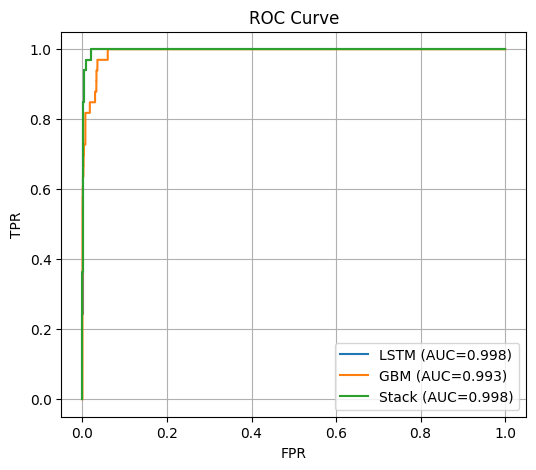

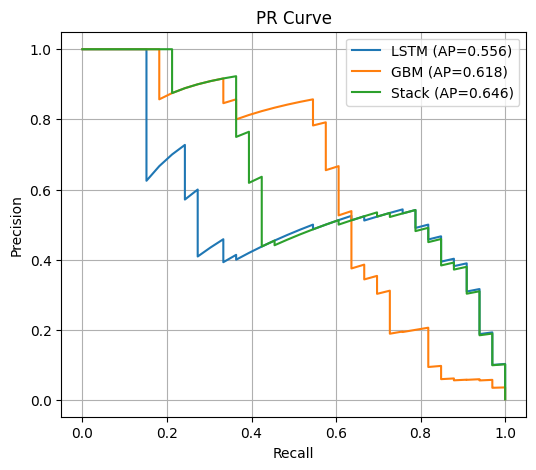

In [25]:

# Visualization functions (re-usable)
def plot_curves(y_true, preds, labels, curve='roc'):
    plt.figure(figsize=(6,5))
    for p, l in zip(preds, labels):
        if curve=='roc':
            fpr,tpr,_ = roc_curve(y_true, p)
            plt.plot(fpr, tpr, label=f"{l} (AUC={roc_auc_score(y_true,p):.3f})")
        else:
            prec,rec,_ = precision_recall_curve(y_true, p)
            plt.plot(rec, prec, label=f"{l} (AP={average_precision_score(y_true,p):.3f})")
    plt.xlabel('Recall' if curve!='roc' else 'FPR')
    plt.ylabel('Precision' if curve!='roc' else 'TPR')
    plt.title(curve.upper() + ' Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Plot
plot_curves(y_val, [p_lstm_val, p_gbm_val, p_stack_val], ['LSTM','GBM','Stack'], curve='roc')
plot_curves(y_val, [p_lstm_val, p_gbm_val, p_stack_val], ['LSTM','GBM','Stack'], curve='pr')


The precision-recall curve shows that the stacking ensemble achieves a higher average precision than either the LSTM or the LightGBM model, highlighting the benefits of creating a stacking ensemble of both models.


## 10. Mock Azure IoT Integration (Formal Notes)

We simulate sending telemetry messages containing the predicted failure probability. In production use:

- Azure IoT Hub device SDK: `azure-iot-device` (Python).
- Securely provision device credentials (SAS tokens or X.509).
- Use asynchronous batching, device twins for model config, and monitor message throughput.

Telemetry message schema (JSON):

$$
\text{msg} = \{\text{deviceId},\; \text{timestamp},\; \text{failureProbability},\; \text{label (optional)}\}.
$$


In [26]:

# Mock Azure IoT Client and simulated sending
class MockAzureIoTClient:
    def __init__(self, device_id='device001'):
        self.device_id = device_id
    def send_message(self, data: dict):
        # In real code: use IoTHubDeviceClient from azure.iot.device
        print('[MOCK Azure IoT] Sending message:', json.dumps(data))

client = MockAzureIoTClient()

# simulate streaming predictions for 5 validation samples
for i in range(5):
    msg = {
        "deviceId": "device001",
        "timestamp": int(time.time()),
        "failureProbability": float(p_stack_val[i]),
        "label": int(y_val[i])
    }
    client.send_message(msg)
    time.sleep(0.5)


[MOCK Azure IoT] Sending message: {"deviceId": "device001", "timestamp": 1764374200, "failureProbability": 0.0006617696200870671, "label": 0}
[MOCK Azure IoT] Sending message: {"deviceId": "device001", "timestamp": 1764374200, "failureProbability": 0.0006618812123471962, "label": 0}
[MOCK Azure IoT] Sending message: {"deviceId": "device001", "timestamp": 1764374201, "failureProbability": 0.0006617562006869577, "label": 0}
[MOCK Azure IoT] Sending message: {"deviceId": "device001", "timestamp": 1764374201, "failureProbability": 0.000661736199985278, "label": 0}
[MOCK Azure IoT] Sending message: {"deviceId": "device001", "timestamp": 1764374202, "failureProbability": 0.0006617883724706857, "label": 0}



## 11. Notes on Productionization and Further Work

- Use **out-of-fold** predictions when training the meta-learner to avoid overfitting.
- Consider **time-aware cross-validation** (e.g., sliding-window) for temporal generalization.
- Add **uncertainty estimation** (e.g., Bayesian neural nets, ensembles, conformal prediction) for calibrated risk scores.
- For deployments, package models with versioning, monitoring (data drift, concept drift), and safe rollback strategies.


## Final notes

This notebook shows how LSTM and LightGBM models for can be combined in a advantageous way into a stacking ensemble with a logistic regression meta-model for the problem of predicting failure over a time horizon.  